<a href="https://colab.research.google.com/github/jplavorr/Data-Science/blob/main/Classificador_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://i.postimg.cc/8CdBQXmP/JPLavor.png">

#### **Data Science**
*by [jplavorr](https://linktr.ee/jplavorr)*  

---

# Classificador de Fake News


Vivemos na era digital, onde a informação está mais acessível do que nunca, e continua ficando cada vez mais acessível, de forma mais ágil e ampla.

Apesar dos benefícios que isso traz, também existem problemas e riscos com isso. Aqui, vamos nos preocupar com um dos maiores deles: ***Fake News***
<p align=center>
  <img src="https://image.freepik.com/free-photo/woman-reading-newspaper_53876-13446.jpg" height="30%">
</p>

Com certeza você já se deparou com uma dessas. Em uma era de informação, a desinformação acaba sendo o nosso maior problema.

Em suma, ***Fake News*** são, como a tradução literal sugere, Notícias Falsas. Elas podem ir desde um número diferente em uma estatística apresentada, até a notícia de uma acontecimento completamente falso.



## Como isso influencia nossa vida?

Como de costume, nós tendemos a acreditar nos grandes veículos de mídia, ou de pessoas do nosso ciclo de amigos que nos encaminham notícias em redes sociais. Dessa forma, criamos o hábito de não checar nossas fontes, e assim, acreditamos e disseminamos notícias falsas, às vezes sem nem saber.

Isso se torna um grande problema quando afeta o resultado de algo importante no bem comum de nossa sociedade, como resultados de eleições, opinião pública sobre determinados projetos, políticas públicas, e até pessoas públicas, sejam elas do meio político, artístico, jornalístico, ou qualquer outro.

In [1]:
!pip install tensorflow -q

     |████████████████████████████████| 462 kB 5.1 MB/s 


In [2]:
# importando os pacotes necessarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
import missingno as msno

# configurando o noteebook
np.random.seed(42)
sns.set_style()

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')


In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
stopwords = stopwords.words("english")

# Fake News Dataset

O conjunto de dados ([que pode ser encontrado aqui](https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php)) contém dois tipos de artigos falsos e notícias reais. Esse conjunto de dados foi coletado de fontes do mundo real; os artigos verídicos foram obtidos rastreando artigos da Reuters.com (Noticiário local na Internet). Quanto aos artigos de notícias falsas, eles foram coletados de diferentes fontes. As notícias falsas artigos foram coletados de sites não confiáveis ​​que foram sinalizados pelo Politifact (um organização nos EUA) e Wikipedia. O conjunto de dados contém diferentes tipos de artigos em diferentes
tópicos, no entanto, a maioria dos artigos se concentra em tópicos de notícias políticas e mundiais.


O conjunto de dados consiste em dois arquivos CSV. O primeiro arquivo chamado “True.csv” contém mais de 12.600
artigos de reuter.com. O segundo arquivo chamado “Fake.csv” contém mais de 12.600 artigos de
diferentes recursos de agências de notícias falsas. Cada artigo inclui as seguintes informações:

- Título do artigo.
- Texto.
- Tipo.  
- Data em que o artigo foi publicado. 

Para corresponder aos dados de notícias falsas coletados para kaggle.com,
focamos principalmente na coleta de artigos de 2016 a 2017. Os dados coletados foram limpos e processadas, porém, as pontuações e os erros nas fake news foram mantidos no texto.

In [5]:
fake = pd.read_csv("/content/drive/MyDrive/Fake.csv")

In [6]:
true = pd.read_csv("/content/drive/MyDrive/True.csv")

In [7]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
#Shape of real news dataset
print("Real news: ", true.shape)
#Shape of fake news dataset
print("Fake News: ", fake.shape)

Real news:  (21417, 4)
Fake News:  (23481, 4)


# Análise Exploratória de Dados

Primeiro, vamos realizar algumas análises para que possamos entender possíveis tendências em nossos dados. Como os datasets de notícias reais e notícias falsas são separados, precisaremos rotular a nossa variável e concatenar os dois datasets. Para o conjunto de dados de notícias reais, fazemos um loop no número de linhas e adicionamos um 0 ao dataframe de notícias reais. Para o conjunto de dados de notícias falsas, repetimos esse procedimento, mas adicionamos 1 (que é nossa variável alvo).

In [10]:
#Adicionar label 1 no fake
fake["Label"] = 1

In [11]:
#Adicionar label 0 no true
true["Label"] = 0

In [12]:
#concatenando os datasets
news = pd.concat([true,fake])
#Sample vai misturar nosso dataset
news = news.sample(frac = 1)

In [13]:
news.head()

,title,text,subject,date,Label
799,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1
6500,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1
3590,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1
1377,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0
11059,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1


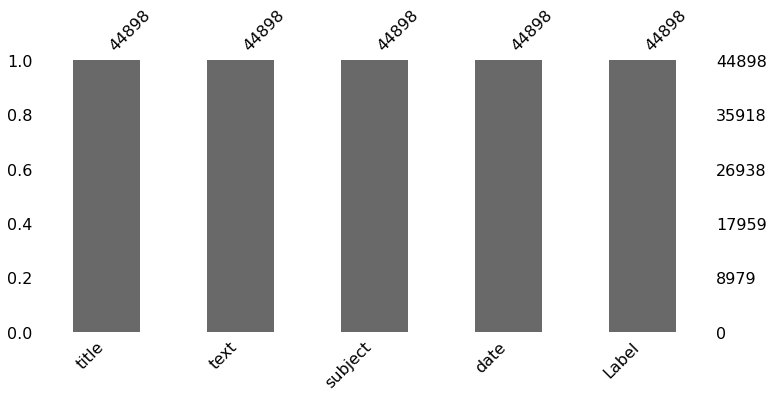

In [14]:
#Plotando dados ausentes
msno.bar(news, figsize=(12,5));

In [15]:
news.drop(columns = "date", axis = 1, inplace=True)

Agora temos exatamente o dataset que precisamos para comecar nosso modelo de machine learning.

In [16]:
all_list = [words for words in news["title"] + " " + news["text"] + " " + news["subject"]]

In [17]:
news["all"] = all_list

In [18]:
print("\nTipo das Variáveis presentes no DataSet:", news.dtypes)
print('\nValores únicos por variável:', news.nunique())
print("\nNome das variáveis:", news.columns.values)


Tipo das Variáveis presentes no DataSet: title      object
text       object
subject    object
Label       int64
all        object
dtype: object

Valores únicos por variável: title      38729
text       38646
subject        8
Label          2
all        44685
dtype: int64

Nome das variáveis: ['title' 'text' 'subject' 'Label' 'all']


Como temos 21.417 amostras de notícias reais e 23.481 amostras de notícias falsas, há uma proporção de aproximadamente 48:52 notícias reais: notícias falsas. Isso significa que nosso conjunto de dados é relativamente equilibrado.

## Tratamento de Texto

In [19]:
stemmer = PorterStemmer() 

In [20]:
df = news.copy()

In [21]:
df.head()

,title,text,subject,Label,all
799,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,1,BREAKING: GOP Chairman Grassley Has Had Enoug...
6500,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,1,Failed GOP Candidates Remembered In Hilarious...
3590,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,1,Mike Pence’s New DC Neighbors Are HILARIOUSLY...
1377,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,0,California AG pledges to defend birth control ...
11059,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,1,AZ RANCHERS Living On US-Mexico Border Destroy...


In [22]:
# Separa a frase em uma lista de sentencas.
df['unstemmed'] = df['all'].str.split()

In [23]:
# Se tiver algo diferente de palavras, ele ira preencher com espaco em branco
df['unstemmed'] = df['unstemmed'].apply(lambda x: [re.sub(r"[^A-Za-z]", " ", y).lower() for y in x])

In [24]:
# Aplica o porter stemmer nessas palavras
df['stemmed'] = df['unstemmed'].apply(lambda x: [stemmer.stem(y) for y in x if not y in stopwords])

In [25]:
# Exclui stopwords.
df['stemmed_stopwords'] = df["stemmed"].apply(lambda x: [item for item in x if item not in stopwords])

In [26]:
df["features"] = df['stemmed_stopwords'].apply(lambda x: ' '.join(x))

In [27]:
df_prod = df[["features", "Label"]]

In [28]:
df_prod.head()

,features,Label
799,breaking gop chairman grassley enough demand...,1
6500,fail gop candid rememb hilari mock eulog vide...,1
3590,mike pence new dc neighbor hilari troll homop...,1
1377,california ag pledg defend birth control insur...,0
11059,az rancher live us mexico border destroy nanci...,1


In [29]:
df_prod.shape

(44898, 2)

### Pré-Processamento de Strings - NLP

Aqui neste projeto, vamos nos concentrar no texto e como você pode construir o classificador baseado em modelos de NLP. Começaremos examinando o sentimento no texto e aprenderemos a construir modelos que entendem o texto treinado em texto rotulado e, em seguida, podemos classificar o novo texto com base no que eles viram.

Quando estávamos lidamos com imagens, é relativamente fácil para nós alimentá-las em uma rede neural, pois os valores dos pixels já eram números. E a rede poderia aprender parâmetros de funções que poderiam ser usados ​​para ajustar classes a rótulos. Mas o que acontece com o texto? Como podemos fazer isso com frases e palavras?


## **Codificações baseadas em palavras**

Poderíamos pegar codificações de caracteres para cada caractere em um conjunto. Por exemplo, os valores ASCII. Mas isso nos ajudará a entender o significado de uma palavra?

Então, por exemplo, considere a palavra 'LISTEN' como mostrado aqui. Uma codificação de caracteres simples comum é ASCII, o American Standard Code for Information Interchange com os valores mostrados aqui:

<img alt="Colaboratory logo" width="50%" src="https://i.postimg.cc/sXJ722t2/imagem0.png">

Podemos pensar que poderia ter uma palavra como LISTEN codificada usando esses valores. Mas o problema com isso, é claro, é que a semântica da palavra não está codificada nas letras. Isso pode ser demonstrado usando a palavra 'SILENT' que tem um significado muito diferente e quase oposto, mas com exatamente as mesmas letras.

Portanto, parece que treinar uma rede neural apenas com as letras pode ser uma tarefa assustadora. Então, que tal se considerarmos as palavras? E se pudéssemos dar um valor às palavras e usar esses valores no treinamento de uma rede? Agora podemos estar chegando a algum lugar. 

Então, por exemplo, considere esta frase, "I love my dog". Que tal dar um valor a cada palavra? Qual é esse valor não importa. É que temos um valor por palavra, e o valor é sempre o mesmo para a mesma palavra.

Assim, uma codificação simples para a frase seria, por exemplo, dar à palavra 'I' o valor um. A seguir, poderíamos dar às palavras 'Love', 'my' e 'dog' os valores 2, 3 e 4 respectivamente

<img alt="Colaboratory logo" width="70%" src="https://i.postimg.cc/WbkCfLr4/imagem1.png">

Então a frase, "I love my dog" seria codificada como 1, 2, 3, 4. Então agora, e se eu tiver a frase, "I love my cat"? Bem, já codificamos as palavras 'I love my' como 1, 2, 3. Assim, podemos reutilizá-las e criar um novo token para cat, que não vimos antes. Então vamos fazer disso o número 5.

<img alt="Colaboratory logo" width="70%" src="https://i.postimg.cc/DzrbCZfc/imagem2.png">

Agora, se olharmos apenas para os dois conjuntos de codificações, podemos começar a ver alguma semelhança entre as sentenças. "I love my dog" é 1, 2, 3, 4 e "I love my cat" é 1, 2, 3, 5. Então esse é pelo menos o começo e como podemos começar a treinar uma rede neural baseada em palavras. Felizmente, o TensorFlow e o Keras nos fornecem algumas APIs que tornam isso muito simples.

Mas antes de começarmos a fazer os Tokens, iremos separar os nossos dados entre treino e teste.

In [30]:
# separando os datasets em treino, validação e teste
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_prod)
train, validation = train_test_split(train, test_size = 0.2)
print('Entradas por Dataset')
print('Dataset de Treino: ',len(train), 'linhas.')
print('Dataset de Validação: ', len(validation), 'linhas.')
print('Dataset de Teste: ', len(test), 'linhas.')

Entradas por Dataset
Dataset de Treino:  26938 linhas.
Dataset de Validação:  6735 linhas.
Dataset de Teste:  11225 linhas.


In [31]:
train.head()

,features,Label
13627,russian media law pose threat free press u s ...,0
13478,russia accus u s tri provok north korean lead...,0
18485,father student releas n korean prison slam ob...,1
13689,import hate intolerance u s ha import ...,1
7267,north korea care presid unit state unit nation...,0


In [32]:
# preparando os dados para o modelo
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>"

In [33]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train.features)
word_index = tokenizer.word_index

Vamos detalhar linha por linha. 


Tensorflow e Keras nos dão várias maneiras de codificar palavras, mas o que vou focar é o **tokenizer**. Isso fará o trabalho pesado para nós, gerando o dicionário de codificações de palavras e criando vetores a partir das frases.

<p align=center>
  <img src="https://www.kdnuggets.com/wp-content/uploads/text-tokens-tokenization-manning.jpg" height="30%">
</p>

Para ler mais sobre esse assunto e entender melhor os passos e parâmetros abaixo, deixarei links de referência [aqui](https://www.kdnuggets.com/2017/12/general-approach-preprocessing-text-data.html) e [aqui](https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html).


Em seguida, crio uma instância do tokenizer. O parâmetro `num_words`. Nesse caso, estou usando 10000, que é se refere ao número de palavras distintas nos dados. Se você estiver criando um conjunto de treinamento com base em muito texto, geralmente não saberá quantas palavras distintas exclusivas existem nesse texto. Então, ao definir esse hiperparâmetro, o que o tokenizer fará é pegar as 10000 principais palavras por volume e apenas codificá-las. É um atalho útil ao lidar com muitos dados e vale a pena experimentar quando você treinar com dados reais, como nosso caso.

O método fit do tokenizer recebe os dados e os codifica. O tokenizer fornece uma propriedade de índice de palavras (`word_index`) que retorna um dicionário contendo pares chave-valor, em que a chave é a palavra e o valor é o token dessa palavra, que você pode inspecionar simplesmente imprimindo-a.

### **Olhando mais para o Tokenizer**

Em primeiro lugar, realmente precisamos de muitos dados de treinamento para obter um vocabulário amplo ou podemos acabar com frases pouco representativas. Em segundo lugar, em muitos casos, é uma boa ideia, em vez de simplesmente ignorar palavras não vistas, colocar um valor especial quando uma palavra não vista é encontrada. Você pode fazer isso com uma propriedade no tokenizer.

Para isso, é preciso adicionar um token de propriedade oov ao construtor do tokenizer. Você pode ver agora que especifiquei que quero que o token `<00v>` para vocabulário externo seja usado para palavras que não estão no índice de palavras. Você pode usar o que quiser aqui, mas lembre-se de que deve ser algo único e distinto que não seja confundido com uma palavra real.

In [34]:
word_index

{'<OOV>': 1,
 'trump': 2,
 'said': 3,
 'u': 4,
 's': 5,
 'would': 6,
 'state': 7,
 'presid': 8,
 'republican': 9,
 'new': 10,
 'one': 11,
 'say': 12,
 'year': 13,
 'peopl': 14,
 'news': 15,
 'also': 16,
 'obama': 17,
 'clinton': 18,
 'like': 19,
 'donald': 20,
 'democrat': 21,
 'govern': 22,
 'time': 23,
 'nation': 24,
 'hous': 25,
 'call': 26,
 'polit': 27,
 'support': 28,
 'unit': 29,
 'could': 30,
 'campaign': 31,
 'go': 32,
 'report': 33,
 'white': 34,
 'reuters': 35,
 'american': 36,
 'make': 37,
 'told': 38,
 'right': 39,
 'elect': 40,
 'vote': 41,
 'two': 42,
 'get': 43,
 'last': 44,
 'it': 45,
 'senat': 46,
 'use': 47,
 'first': 48,
 'back': 49,
 'includ': 50,
 'work': 51,
 'take': 52,
 'want': 53,
 'th': 54,
 'offici': 55,
 'washington': 56,
 'law': 57,
 'even': 58,
 'us': 59,
 'video': 60,
 'group': 61,
 'former': 62,
 'parti': 63,
 'hillari': 64,
 'media': 65,
 'court': 66,
 'secur': 67,
 'countri': 68,
 'day': 69,
 'show': 70,
 'mani': 71,
 'week': 72,
 'may': 73,
 'plan': 

O próximo passo será transformar suas sentenças em listas de valores baseadas nesses tokens. Depois de tê-los, você provavelmente também precisará manipular essas listas, principalmente para fazer com que todas as frases tenham o mesmo tamanho, caso contrário, pode ser difícil treinar uma rede neural com eles. Lembre-se quando trabalhamos imagens, definimos uma camada de entrada com o tamanho da imagem que estamos alimentando na rede neural. Nos casos em que as imagens tivessem tamanhos diferentes, nós as redimensionávamos para caber. Bem, você vai enfrentar a mesma coisa com o texto. Felizmente, o TensorFlow inclui APIs para lidar com esses problemas.

In [35]:
# aplicando técnicas tokenizing e padding
training_sequences = tokenizer.texts_to_sequences(np.array(train.features))

Vamos começar criando uma lista de sequências, as frases codificadas com os tokens que geramos. Observe que todas as frases anteriores continham quatro palavras. Então esse é um pouco mais longo. Usaremos isso para demonstrar o preenchimento em um momento.

O próximo pedaço de código é este, onde eu simplesmente chamo o tokenizer para obter textos para sequências, e ele os transformará em um conjunto de sequências. 

Por exemplo, se aplicarmos o tokenizer na frase "I love my dog", teremos o seguinte word_index: `{'my': 1, 'love': 2, 'dog': 3, 'i': 4}` e o `text_to_sequence` retornará a seguinte sequência: `[4, 2, 1, 3]`.


In [36]:
training_sequences[0:1]

[[113,
  65,
  57,
  1494,
  410,
  346,
  265,
  4,
  5,
  7,
  139,
  56,
  35,
  4,
  5,
  7,
  139,
  3,
  128,
  10,
  57,
  181,
  80,
  260,
  762,
  451,
  112,
  65,
  1579,
  112,
  796,
  1494,
  410,
  346,
  265,
  649,
  682,
  47,
  679,
  3278,
  203,
  65,
  7,
  139,
  1032,
  4512,
  5653,
  3,
  96,
  128,
  721,
  7555,
  50,
  241,
  65,
  22,
  73,
  361,
  1,
  512,
  371,
  39,
  2319,
  80,
  1022,
  3403,
  3,
  80,
  112,
  796,
  57,
  47,
  2442,
  3653,
  3063,
  1,
  5286,
  292,
  1939,
  573,
  2373,
  694,
  409,
  302,
  51,
  57,
  296,
  8,
  1377,
  486,
  510,
  181,
  682,
  114,
  112,
  65,
  1676,
  15,
  245,
  113,
  51,
  112,
  796,
  1763,
  183,
  2493,
  388,
  2223,
  80,
  653,
  42,
  72,
  29,
  7,
  435,
  113,
  7,
  1178,
  2554,
  1474,
  4,
  5,
  878,
  2283,
  206,
  112,
  796,
  5653,
  827,
  3488,
  4,
  5,
  113,
  1927,
  12,
  36,
  57,
  760,
  99,
  231,
  1101,
  302,
  1181,
  1,
  159,
  115,
  4793,
  337,
  80,

## Padding

Uma vez que o tokenizer tenha criado as sequências, essas sequências podem ser passadas para sequências de preenchimento para que sejam preenchidas assim:

Tokenizer Word_index:
- `{'do': 8, 'you': 6, 'love': 3, 'i': 5, 'amazing': 11, 'my': 2, 'is': 10, 'think': 9,'dog': 4, '<00V>': 1, 'cat': 7} `

Sequence:
- `[[5, 3, 2, 4], [5, 3, 2, 7], [6, 3, 2, 4], [8, 6, 9, 2, 4, 10, 11]]`

Padding:

- `[[ 0 0 0 5 3 2 4]
[ 0 0 0 5 3 2 7]
[ 0 0 0 6 3 2 4]
[ 8 6 9 2 4 10 11]]`

Agora você pode ver que a lista de sentenças foi preenchida em uma matriz e que cada linha na matriz tem o mesmo comprimento. Ele conseguiu isso colocando o número apropriado de zeros antes da sentença. Então, no caso da sentença `[5, 3, 2, 4]`, ela realmente fez qualquer coisa. No caso da frase mais longa `[8, 6, 9, 2, 4, 10, 11]` aqui não precisou fazer nada.

Muitas vezes você verá exemplos em que o preenchimento de zeros está após a frase e não antes, como você acabou de ver. Se você, como eu, estiver mais confortável com isso, você pode alterar o código para isso, adicionando o parâmetro `padding = post` como fizemos acima.

Você deve ter notado que o número de colunas da matriz é de mesmo tamhanho da frase mais longa. Mas você pode substituir isso com o parâmetro `maxlen`. Por exemplo, se você quiser que suas frases tenham no máximo cinco palavras. Você pode dizer que `maxlen` é igual a cinco. Isso, obviamente, levará à pergunta:

Se eu tiver frases mais longas que o comprimento máximo, perderei informações, mas de onde ? 

Assim como no preenchimento, o padrão é pré, o que significa que você perderá desde o início da frase. Se você quiser substituir isso para perder no final, poderá fazê-lo com o parâmetro `truncating`.

In [37]:
training_padded = pad_sequences(training_sequences,truncating=trunc_type, padding=pad_type)

In [38]:
max_length = len(training_padded[0])

In [39]:
max_length

5132

In [40]:
validation_sequences = tokenizer.texts_to_sequences(np.array(validation.features))
validation_padded = pad_sequences(validation_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

In [41]:
# criando arrays com inputs
x_train = np.copy(training_padded)
x_val = np.copy(validation_padded)
y_train = train['Label'].values
y_val = validation['Label'].values

In [42]:
# veriificando o tamanho dos arrays
print('Tamanho dos Arrays')
print('Treino: ', len(x_train), 'linhas.')
print('Resposta: ', len(y_train), 'linhas.')

Tamanho dos Arrays
Treino:  26938 linhas.
Resposta:  26938 linhas.


# Word Embeddings

Até então, estavamos transformando texto em sequências de números aonde cada número da sequência está associado com uma palavra. Por exemplo, você pode representar a palavra TensorFlow com o valor nove e, em seguida, substituir cada instância da palavra por nove em uma sequência. Usando ferramentas e TensorFlow, você pode processar strings para obter índices de todas as palavras em um corpus de strings e depois converter as strings em matrizes de números. Este é o começo para tirar o sentimento de suas frases. Mas agora, ainda é apenas uma sequência de números representando palavras. Então, a partir daí, como alguém realmente obteria sentimento?

Bem, isso é algo que pode ser aprendido a partir de um corpus de palavras da mesma forma que características foram extraídas de imagens. Esse processo é chamado de incorporação, com a ideia de que palavras e palavras associadas são agrupadas como vetores em um espaço multidimensional.


Até agora, criamos uma instância de tokenizer, dando-lhe o tamanho do nosso vocabulário. Agora ajustaremos o tokenizer em nosso conjunto de dados de treinamento. Assim que tivermos nosso índice de palavras, podemos substituir as strings que contêm as palavras pelo valor do token que criamos para elas. As frases terão comprimentos variantes, dessa forma preenchemos e truncamos as sentenças sequenciadas até que elas tenham o mesmo tamanho, determinado pelo parâmetro de comprimento máximo. Então fizemos o mesmo para as sequências de teste e validação. Observe que o índice de palavras são palavras derivadas do conjunto de treinamento, portanto, você deve esperar ver muito mais tokens de vocabulário no exame de teste. 

Agora é hora de definir nossa rede neural. 

# Rede Neural

In [43]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), 
                      metrics=['accuracy'])
history = model.fit(x_train, y_train, verbose = 1, epochs = 5, validation_data = (x_val, y_val),
                   callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=6)])

Epoch 1/5
842/842 [==============================] - 11s 13ms/step - loss: 0.5779 - accuracy: 0.7273 - val_loss: 0.3090 - val_accuracy: 0.9405
Epoch 2/5
842/842 [==============================] - 10s 12ms/step - loss: 0.1869 - accuracy: 0.9665 - val_loss: 0.1248 - val_accuracy: 0.9768
Epoch 3/5
842/842 [==============================] - 10s 12ms/step - loss: 0.0898 - accuracy: 0.9834 - val_loss: 0.0765 - val_accuracy: 0.9850
Epoch 4/5
842/842 [==============================] - 10s 12ms/step - loss: 0.0543 - accuracy: 0.9895 - val_loss: 0.0604 - val_accuracy: 0.9871
Epoch 5/5
842/842 [==============================] - 10s 12ms/step - loss: 0.0362 - accuracy: 0.9931 - val_loss: 0.0419 - val_accuracy: 0.9911


Isso deve parecer muito familiar agora, exceto talvez por esta linha embedding. Essa é a chave para a análise de sentimentos de texto no TensorFlow, e é aí que a mágica realmente acontece. Ao termino do treino, podemos ver que temos uma acurácia muito alta, o que leva a crer que nosso modelo está prevendo bem as as as Fake News com apenas 5 epcochs.

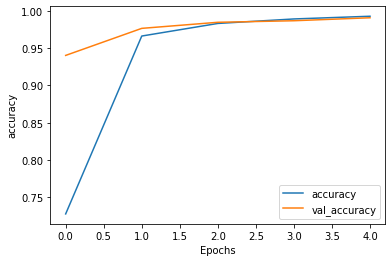

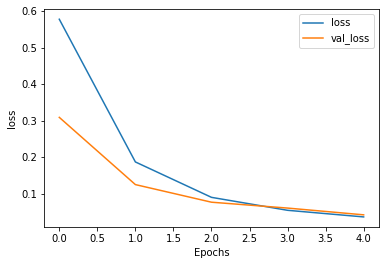

In [45]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Nesse gráfico, podemos ver tanto a redução da nossa função de perda(gráfico 2) quanto no ganho da nossa acurácia(gráfico 1). 

### Fazendo Previsões no Conjunto de Teste

Uma acurácia alta é algo muito bom, porém sempre temos que ter cuidado com overfiting, portanto, vamos aplicar o nosso modelo ao conjunto de teste que deixamos separado anteriormente e ver como ele irá performar em dados não vistos. Como antes, temos que passar nossos dados de teste para o tokenizer.

In [46]:
# tratando os dados de teste
test_sequences = tokenizer.texts_to_sequences(np.array(test.features))
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

In [47]:
# fazendo previsões
preds = np.round(model.predict(test_padded))

In [48]:
# verificando a acurácia
acc = np.sum(1 if i==j else 0 for i,j in zip(preds, test["Label"].values)) / len(test)
print("Accuracy: ", acc )

Accuracy:  0.9914476614699332


Podemos ver que a acurácia no conjunto de teste performou melhor do que no conjunto de validação, dando indicíos de que o nosso modelo está prevendo notoriamente bem a classificação de cada notícia. 

Agora, irei usar uma artimnha do tensorflow, chamado [embedding projector](http://projector.tensorflow.org/) para plotar nossos embeddings em três dimensões. Pressione o botão ''Load Data'' à esquerda. Seguindo o código abaixo, você verá uma caixa de diálogo solicitando que você carregue dados do seu computador. Use vector.TSV para o primeiro e meta.TSV para o segundo. Depois aplique a esferização e você terá uma imagem dessa forma:

In [49]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights. shape) # shape: (vocab_size, embedding dim) shape: (vocab_size, embedding_dim)

(10000, 16)


In [50]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [51]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str (x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [52]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<img alt="Colaboratory logo" width="80%" src="https://i.postimg.cc/g0Q7nsc7/Captura-de-tela-de-2022-04-25-19-12-33.png">


Essa é uma boa forma de visualizarmos os embeddings gerados e podemos ver como ele classifica as palavras mais presentes dentro as fake news e das noticias verdadeiras. Também dando fortes indicios que de não tivemos overfiting.


# Conclusão

Com esse projeto, pudemos ver o quão poderosas são as redes neurais e como usar pre processamento de texto para carregar informações de texto para alimentá-las. Usando embeddings pudemos criar um classificador de Fake News com 99% de acurácia.